### This notebook does not use reversible jump when sampling fourier terms. 
It samples all (1, 2, 3, 4, 6). Multiplicity 5 is skipped because it's usually not used in CHARMM.

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
import simtk.openmm as mm
from torsionfit import TorsionScanSet as ScanSet
import torsionfit.TorsionFitModel as Model
from torsionfit import sqlite_plus
from pymc import MCMC
from parmed.charmm import CharmmParameterSet
from torsionfit import plots
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np

In [3]:
param_to_opt=[('CG331', 'CG321', 'CG321', 'CG331')]
param = CharmmParameterSet('../../../../data/charmm_ff/top_all36_cgenff.rtf', 
                           '../../../../data/charmm_ff/par_all36_cgenff.prm')
structure = '../../../structure/butane.psf'
scan = '../../../torsion_scans/MP2_torsion_scan/'
# Print initial guess
print param.dihedral_types[param_to_opt[0]]

# Create a butane scan with torsions on (to compare for difference potential)
butane_scan = ScanSet.parse_psi4_out(scan, structure)
butane_scan.compute_energy(param)
optimized = butane_scan.remove_nonoptimized()
optimized.compute_energy(param)

# Turn off torsion
param.dihedral_types[('CG331', 'CG321', 'CG321', 'CG331')][1].phi_k=0
param.dihedral_types[('CG331', 'CG321', 'CG321', 'CG331')][0].phi_k=0

# Create butane scan with torsions off
optimized_0 = butane_scan.remove_nonoptimized()
optimized_0.compute_energy(param)

<DihedralTypes [<DihedralType; phi_k=0.038, per=2, phase=0.000,  scee=1.000, scnb=1.000>, <DihedralType; phi_k=0.032, per=6, phase=180.000,  scee=1.000, scnb=1.000>]>
[Psi /Users/sternc1/src/ChayaSt/torsionfit_qm/examples/butane/sampling_torsions/c_c_c_c_torsion/decouple_n/../../../torsion_scans/MP2_torsion_scan/0/butane_0.out2 WARNING] In logfileparser.py, line 468, line not all dashes as expected: --------------------------------------------------------------------------------------------- ~
[Psi /Users/sternc1/src/ChayaSt/torsionfit_qm/examples/butane/sampling_torsions/c_c_c_c_torsion/decouple_n/../../../torsion_scans/MP2_torsion_scan/10/butane_10.out2 WARNING] In logfileparser.py, line 468, line not all dashes as expected: --------------------------------------------------------------------------------------------- ~
[Psi /Users/sternc1/src/ChayaSt/torsionfit_qm/examples/butane/sampling_torsions/c_c_c_c_torsion/decouple_n/../../../torsion_scans/MP2_torsion_scan/20/butane_20.out2 WA

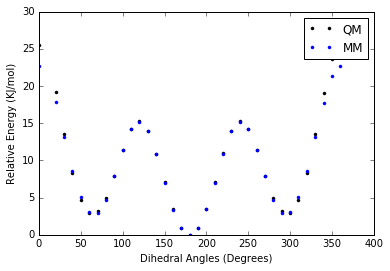

In [4]:
plt.plot(optimized.steps, optimized.qm_energy, 'k.', label='QM')
plt.plot(optimized.steps, optimized.mm_energy, '.', label='MM')
plt.xlabel('Dihedral Angles (Degrees)')
plt.ylabel('Relative Energy (KJ/mol)')
plt.legend()

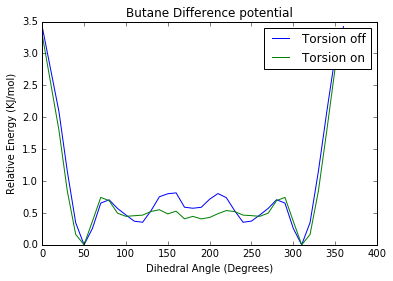

In [5]:
plt.plot(optimized_0.steps, optimized_0.delta_energy-min(optimized_0.delta_energy), label='Torsion off')
plt.plot(optimized.steps, optimized.delta_energy-min(optimized.delta_energy), label='Torsion on')
plt.legend()
plt.xlabel('Dihedral Angle (Degrees)')
plt.ylabel('Relative Energy (KJ/mol)')
plt.title('Butane Difference potential')

In [5]:
platform = mm.Platform.getPlatformByName('Reference')
model = Model.TorsionFitModelEliminatePhase(param, optimized, platform=platform, decouple_n=True, 
                                            param_to_opt=param_to_opt)
sampler = MCMC(model.pymc_parameters, db=sqlite_plus, dbname='butane_decouple_n.database', verbose=5)

In [8]:
sampler.sample(100000)

 [-----------------100%-----------------] 100001 of 100000 complete in 8278.6 sec

In [7]:
db = sqlite_plus.load('butane_decouple_n.database')

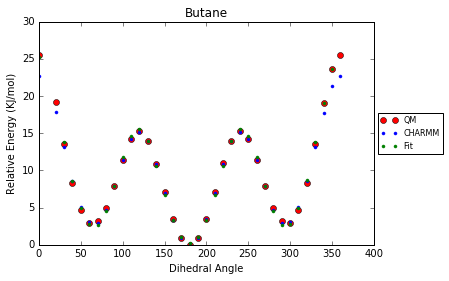

In [46]:
# Remove unoptimized steps (previous torsion scan used in this database had more unconverged structures)
steps = butane_scan.steps
rm = [1, 2, 36]
steps = np.delete(steps, rm)
plt.plot(optimized.steps, optimized.qm_energy, 'ro', label='QM')
plt.plot(optimized.steps, optimized.mm_energy, 'b.', label='CHARMM')
plt.plot(steps, db.trace('mm_energy')[-1], 'g.', label='Fit')
plt.title('Butane')
plt.xlabel('Dihedral Angle')
plt.ylabel('Relative Energy (KJ/mol)')
lgd = plt.legend(prop={'size': 8}, loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('Energy_fit.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.savefig('Energy_fit.png', bbox_extra_artists=(lgd,), bbox_inches='tight')

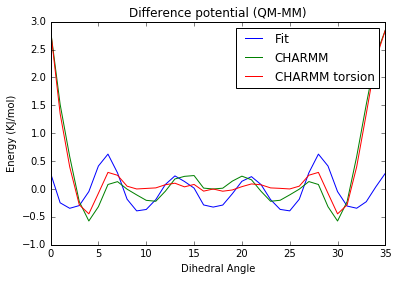

In [20]:
# reparameterize 
param_new = CharmmParameterSet('../data/charmm_ff/top_all36_cgenff.rtf', '../data/charmm_ff/par_all36_cgenff.prm')
charmm_torsion = optimized_0.remove_nonoptimized()
charmm_torsion.compute_energy(param_new)
plt.plot(optimized.delta_energy, label='Fit')
plt.plot(optimized_0.delta_energy, label='CHARMM')
plt.plot(charmm_torsion.delta_energy, label='CHARMM torsion')
plt.title('Difference potential (QM-MM)')
plt.xlabel('Dihedral Angle')
plt.ylabel('Energy (KJ/mol)')
plt.legend()
plt.savefig('diff_pot.pdf')

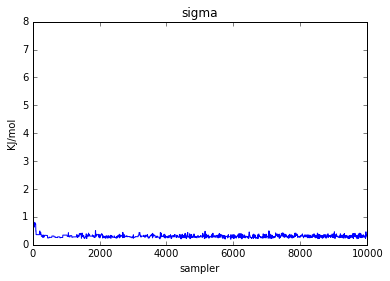

In [65]:
plt.plot(np.exp(db.log_sigma[:]))
plt.title('sigma')
plt.xlabel('sampler')
plt.ylabel('KJ/mol')
plt.savefig('sigma_decouple_n.pdf')

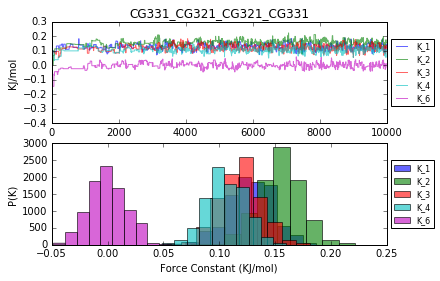

In [64]:
alpha = 0.6
plt.subplot(2, 1, 1)
plt.title('CG331_CG321_CG321_CG331')
plt.plot(db.trace('CG331_CG321_CG321_CG331_1_K')[:], label='K_1', alpha=alpha)
plt.plot(db.trace('CG331_CG321_CG321_CG331_2_K')[:], label='K_2', alpha=alpha)
plt.plot(db.trace('CG331_CG321_CG321_CG331_3_K')[:], label='K_3', alpha=alpha)
plt.plot(db.trace('CG331_CG321_CG321_CG331_4_K')[:], label='K_4', alpha=alpha)
plt.plot(db.trace('CG331_CG321_CG321_CG331_6_K')[:], label='K_6', alpha=alpha)
plt.xlabel('samples')
plt.ylabel('KJ/mol')
lgd = plt.legend(prop={'size': 8}, loc='center left', bbox_to_anchor=(1, 0.5))

plt.subplot(2, 1, 2)
plt.hist(db.trace('CG331_CG321_CG321_CG331_1_K')[1000:], label='K_1', alpha=alpha)
plt.hist(db.trace('CG331_CG321_CG321_CG331_2_K')[1000:], label='K_2', alpha=alpha)
plt.hist(db.trace('CG331_CG321_CG321_CG331_3_K')[1000:], label='K_3', alpha=alpha)
plt.hist(db.trace('CG331_CG321_CG321_CG331_4_K')[1000:], label='K_4', alpha=alpha)
plt.hist(db.trace('CG331_CG321_CG321_CG331_6_K')[1000:], label='K_6', alpha=alpha)
plt.xlabel('Force Constant (KJ/mol)')
plt.ylabel('P(K)')
lgd = plt.legend(prop={'size': 8}, loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('trace_hist.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')

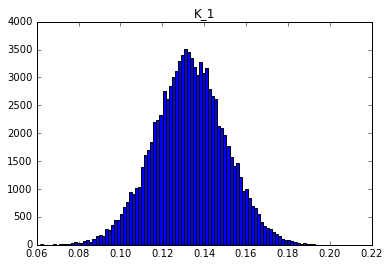

In [22]:
plt.hist(sampler.trace('CG331_CG321_CG321_CG331_1_K')[2000:], bins=100)
plt.title('K_1')

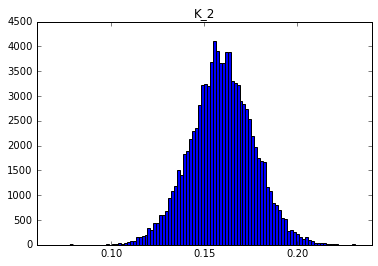

In [23]:
plt.hist(sampler.trace('CG331_CG321_CG321_CG331_2_K')[2000:], bins=100)
plt.title('K_2')

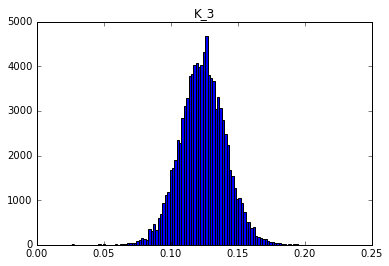

In [24]:
plt.hist(sampler.trace('CG331_CG321_CG321_CG331_3_K')[2000:], bins=100)
plt.title('K_3')

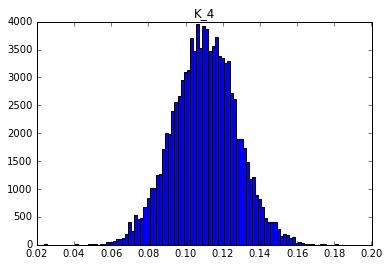

In [25]:
plt.hist(sampler.trace('CG331_CG321_CG321_CG331_4_K')[2000:], bins=100)
plt.title('K_4')

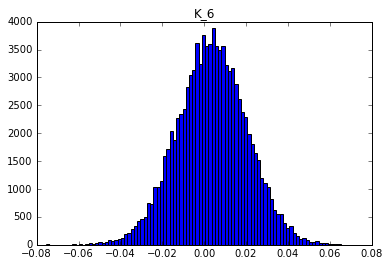

In [26]:
plt.hist(sampler.trace('CG331_CG321_CG321_CG331_6_K')[2000:], bins=100)
plt.title('K_6')

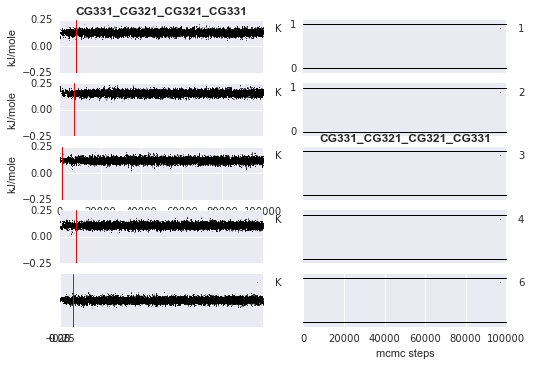

In [31]:
import seaborn
db = sqlite_plus.load('butane_decouple_n.database')
plots.trace_no_phase('CG331_CG321_CG321_CG331', sampler, markersize=1.0, ymin=-0.25, ymax=0.25, 
                     filename='decouple_n/trace_decouple_n.pdf')

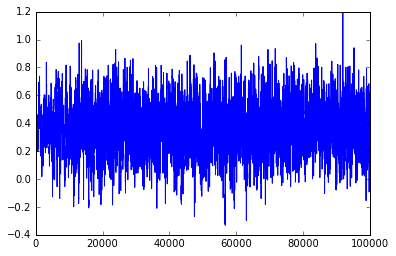

In [30]:
plt.plot(sampler.BUTA1_offset.trace[:])